# Analyze Visium H&E data

Notebook from [https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html)

## Import packages & data

In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq
import pandas as pd
import numpy as np

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.18.5 scipy==1.4.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.2
squidpy==1.1.2


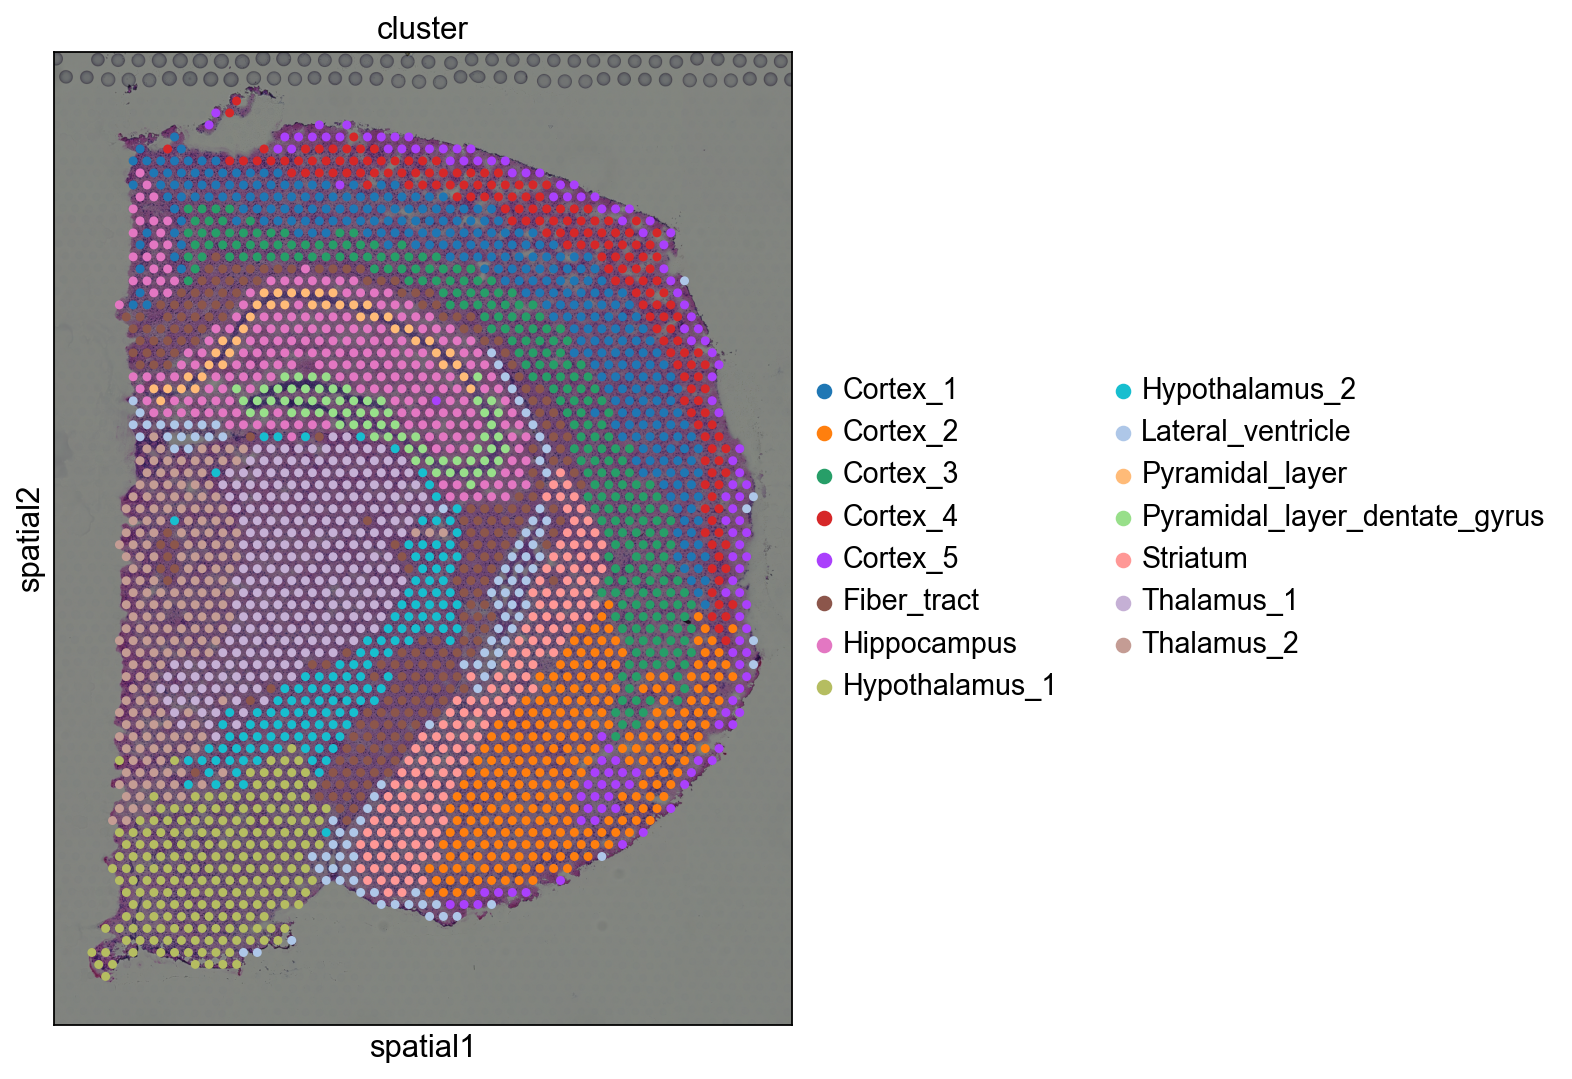

In [2]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color="cluster")

## Image features

In [3]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

100%|██████████| 2688/2688 [00:39<00:00, 68.52/s]


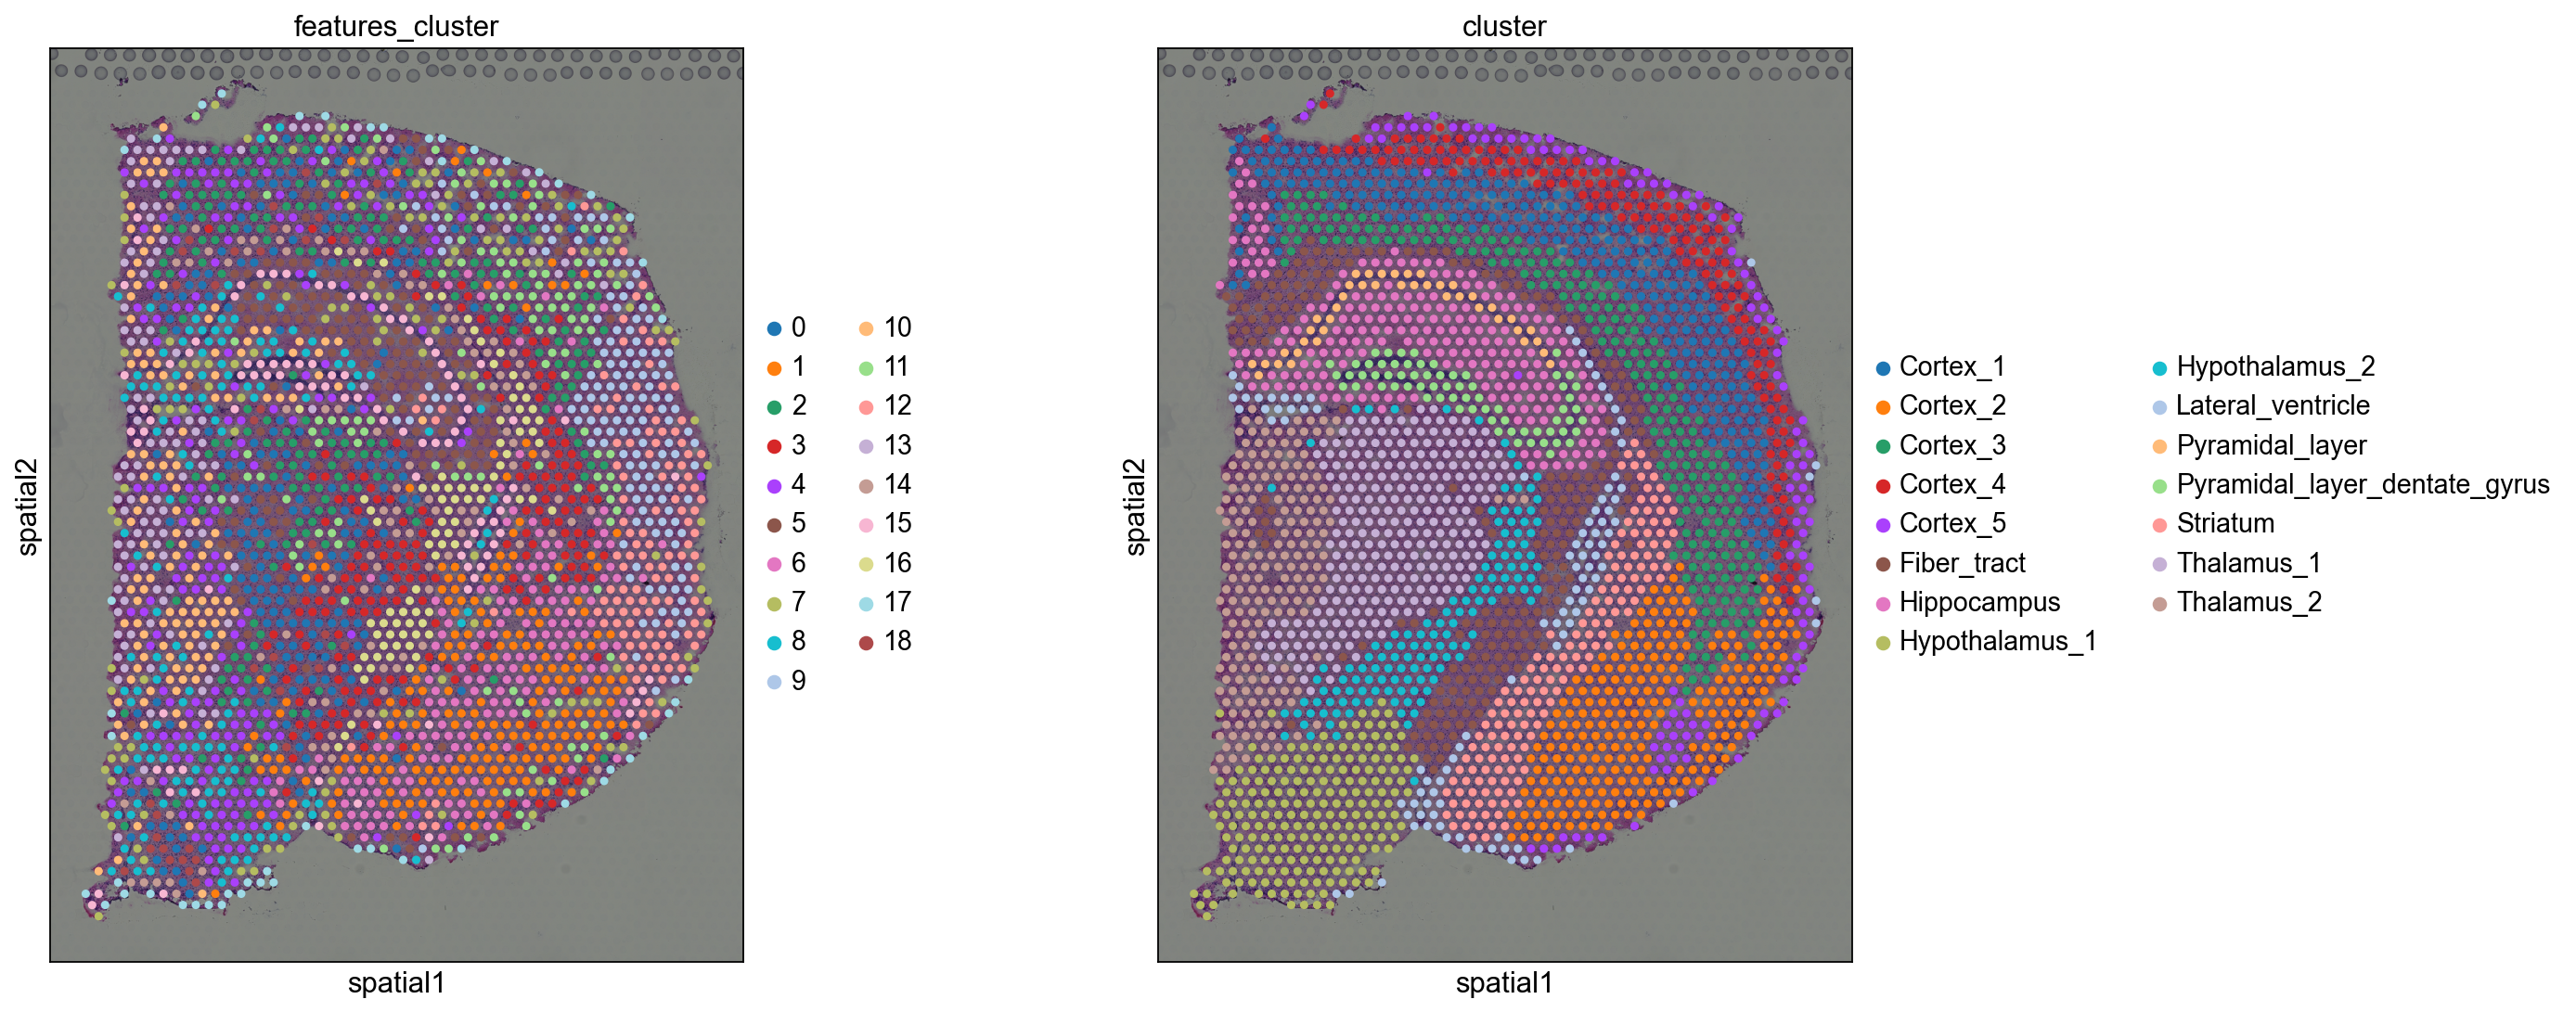

In [4]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "cluster"])

## Create TissUUmaps CSV

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'features_cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'features_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'features_summary_scale1.0', 'features_summary_scale2.0', 'features'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [6]:
results = adata.obs[['leiden', 'cluster', 'features_cluster']]
results

leiden            cluster features_cluster
AAACAAGTATCTCCCA-1      2           Cortex_2               12
AAACAATCTACTAGCA-1     11           Cortex_5               13
AAACACCAATAACTGC-1      7         Thalamus_2                8
AAACAGAGCGACTCCT-1     11           Cortex_5               12
AAACCGGGTAGGTACC-1      7         Thalamus_2               10
...                   ...                ...              ...
TTGTTGTGTGTCAAGA-1     12  Lateral_ventricle               14
TTGTTTCACATCCAGG-1      6     Hypothalamus_1               18
TTGTTTCATTAGTCTA-1      6     Hypothalamus_1                4
TTGTTTCCATACAACT-1      7         Thalamus_2               10
TTGTTTGTGTAAATTC-1      8           Cortex_4                7

[2688 rows x 3 columns]

In [7]:
coords = pd.DataFrame(data = np.hstack([adata.obsm['spatial'], adata.obsm['X_umap']]),
             columns=["image_X", "image_Y","UMAP_X", "UMAP_Y"],
             index=results.index)
coords

image_X  image_Y     UMAP_X    UMAP_Y
AAACAAGTATCTCCCA-1   8230.0   7237.0  -0.485949 -1.308951
AAACAATCTACTAGCA-1   4170.0   1611.0  -0.643395  1.128548
AAACACCAATAACTGC-1   2519.0   8315.0  11.860388  1.217252
AAACAGAGCGACTCCT-1   7679.0   2927.0  -1.231810  0.883202
AAACCGGGTAGGTACC-1   3138.0   6280.0  16.642550  1.060034
...                     ...      ...        ...       ...
TTGTTGTGTGTCAAGA-1   6509.0   4963.0   6.953657  3.487158
TTGTTTCACATCCAGG-1   4101.0   8195.0  10.190333  0.260366
TTGTTTCATTAGTCTA-1   3276.0   8435.0  10.546704  0.428959
TTGTTTCCATACAACT-1   3069.0   6639.0  16.207390  1.081706
TTGTTTGTGTAAATTC-1   4720.0   2090.0  -4.060462 -0.461689

[2688 rows x 4 columns]

In [8]:
df = pd.concat([coords, results], axis=1)
df

image_X  image_Y     UMAP_X    UMAP_Y leiden  \
AAACAAGTATCTCCCA-1   8230.0   7237.0  -0.485949 -1.308951      2   
AAACAATCTACTAGCA-1   4170.0   1611.0  -0.643395  1.128548     11   
AAACACCAATAACTGC-1   2519.0   8315.0  11.860388  1.217252      7   
AAACAGAGCGACTCCT-1   7679.0   2927.0  -1.231810  0.883202     11   
AAACCGGGTAGGTACC-1   3138.0   6280.0  16.642550  1.060034      7   
...                     ...      ...        ...       ...    ...   
TTGTTGTGTGTCAAGA-1   6509.0   4963.0   6.953657  3.487158     12   
TTGTTTCACATCCAGG-1   4101.0   8195.0  10.190333  0.260366      6   
TTGTTTCATTAGTCTA-1   3276.0   8435.0  10.546704  0.428959      6   
TTGTTTCCATACAACT-1   3069.0   6639.0  16.207390  1.081706      7   
TTGTTTGTGTAAATTC-1   4720.0   2090.0  -4.060462 -0.461689      8   

                              cluster features_cluster  
AAACAAGTATCTCCCA-1           Cortex_2               12  
AAACAATCTACTAGCA-1           Cortex_5               13  
AAACACCAATAACTGC-1         Thalamus_2                8  
AAACAGAGCGACTCCT-1           Cortex_5               12  
AAACCGGGTAGGTACC-1         Thalamus_2               10  
...                               ...              ...  
TTGTTGTGTGTCAAGA-1  Lateral_ventricle               14  
TTGTTTCACATCCAGG-1     Hypothalamus_1               18  
TTGTTTCATTAGTCTA-1     Hypothalamus_1                4  
TTGTTTCCATACAACT-1         Thalamus_2               10  
TTGTTTGTGTAAATTC-1           Cortex_4                7  

[2688 rows x 7 columns]

In [9]:
from sklearn.preprocessing import MinMaxScaler

df.UMAP_X = np.array(pd.DataFrame(MinMaxScaler((df.image_X.min(), df.image_X.max())).fit_transform(np.expand_dims(df.UMAP_X,1))))
df.UMAP_Y = np.array(pd.DataFrame(MinMaxScaler((df.image_Y.min(), df.image_Y.max())).fit_transform(np.expand_dims(df.UMAP_Y,1))))

In [10]:
df.to_csv('squidpy_tissuumaps.csv')